<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/main/notebooks/W7%20Spatial%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spatial Regression in Python

This notebook demostrates how to fit spatial lag model and spatial error model using pysal's `spreg` library.


- OLS
- Spatial Error Model
- Spatial Lag Model
- Comparison of the three models
- Exploration of direct and indirect effects in the lag model

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

Below are some packages that may not be available on Google Colab. You could simply install them (e.g. the spreg library) using `pip install libpysal`.

More details about these PySAL libraries can be found [https://pysal.org/](https://pysal.org/)

In [2]:
pip install -q libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.0 MB/s eta 0:00:00


In [3]:
pip install -q splot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 10.6 MB/s eta 0:00:00


In [4]:
from libpysal.weights import Queen
from splot.esda import plot_moran
from esda.moran import Moran
import spreg

### Data
In this notebook, I will be using a 2020 US presidential election dataset to do the demostration.
The `voting` dataframe contains county level pct of people voted for the democratic party coded as `new_pct_dem` as well as some socio-econ variables of that county. The dataset only has statistics of the lower 48 states.

In [5]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020.csv')

voting[['median_income']] = voting[['median_income']]/10000

In [6]:
voting.head()

,county_id,state,county,NAME,proj_X,proj_Y,total_pop,new_pct_dem,sex_ratio,pct_black,...,median_income,pct_65_over,pct_age_18_29,gini,pct_manuf,ln_pop_den,pct_3rd_party,turn_out,pct_fb,pct_uninsured
0,17051,17,51,"Fayette County, Illinois",597979.5531,1796861.993,21565,18.445122,113.6,4.7,...,4.6650,18.8,14.899142,0.4373,14.9,3.392715,1.923652,58.930984,1.3,8.2
1,17107,17,107,"Logan County, Illinois",559814.6766,1920479.975,29003,29.420030,97.2,6.9,...,5.7308,18.0,17.256836,0.4201,12.4,3.847224,2.332850,56.631552,1.6,4.5
2,17165,17,165,"Saline County, Illinois",650278.3579,1660709.808,23994,25.601911,96.9,2.6,...,4.4090,19.9,13.586730,0.4692,8.7,4.128654,1.778139,59.147937,1.0,4.2
3,17097,17,97,"Lake County, Illinois",654010.9262,2174576.605,701473,62.275888,99.8,6.8,...,8.9427,13.7,15.823132,0.4847,16.3,7.308201,1.954177,71.151975,18.7,6.8
4,17127,17,127,"Massac County, Illinois",640398.9863,1599902.491,14219,25.626118,89.5,5.8,...,4.7481,20.8,12.370772,0.4097,7.4,4.067788,1.396443,62.281425,1.0,5.4


We then read a couty boundary file of the US.

In [7]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [8]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP').geometry.boundary

Select the variables to be used in this exercise, I picked 6 predictors from the list.

In [9]:
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']


y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

### OLS model (baseline)

Here I demostrate how to use `spreg` to fit an OLS model. Of course you can also use `statsmodels`.

In [10]:
#In the spreg.OLS() you need to specify the y and X, also variable names (optional)

ols = spreg.OLS(y, X, name_y='new_pct_dem', name_x=variable_names)

In [11]:
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : new_pct_dem                Number of Observations:        3103
Mean dependent var  :     33.7616                Number of Variables   :           7
S.D. dependent var  :     16.2257                Degrees of Freedom    :        3096
R-squared           :      0.6091
Adjusted R-squared  :      0.6083
Sum squared residual:      319249                F-statistic           :    803.9833
Sigma-square        :     103.117                Prob(F-statistic)     :           0
S.E. of regression  :      10.155                Log likelihood        :  -11592.001
Sigma-square ML     :     102.884                Akaike info criterion :   23198.003
S.E of regression ML:     10.1432                Schwarz criterion     :   23240.284

------------------------------------------------------------

We can compare with statsmodels, same results

Check out the OLS residuals map

In [12]:
ols.u

array([[ 0.98102642],
       [-7.61122909],
       [ 3.44911401],
       ...,
       [-3.82424613],
       [-0.7422498 ],
       [-1.11507546]])

Text(0.5, 1.0, 'Map of residuals of the OLS model')

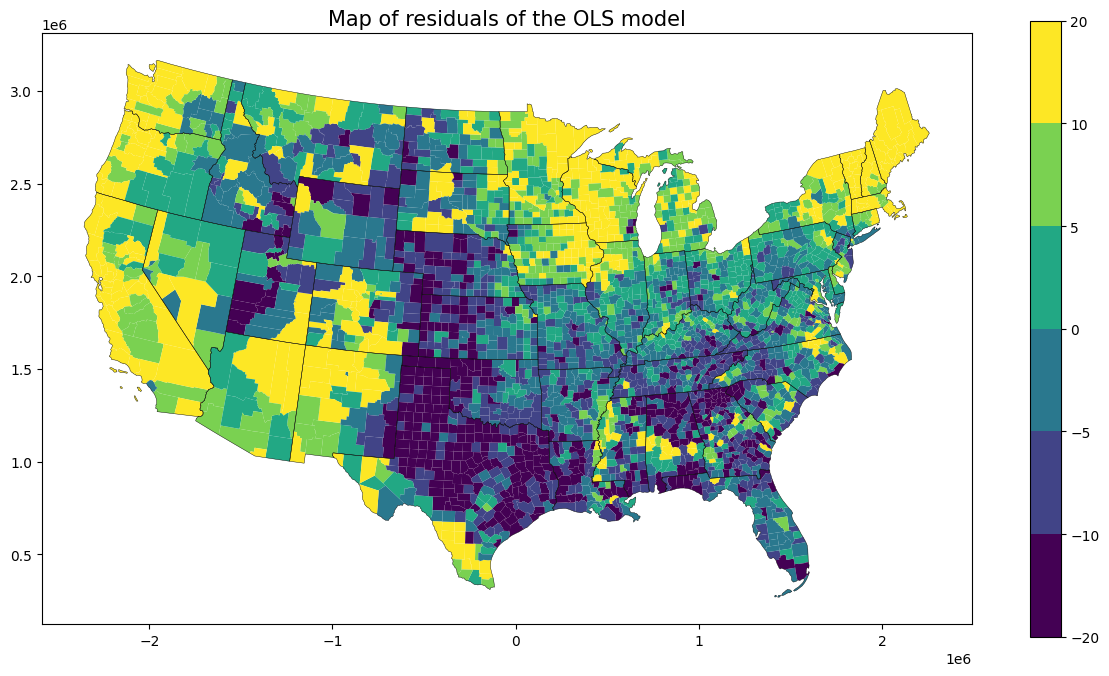

In [13]:
from matplotlib import colors

#For creating a discrete color classification
norm = colors.BoundaryNorm([-20, -10, -5, 0, 5, 10, 20],ncolors=256)

ax = shp_voting.plot(column=ols.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

state.plot(ax=ax,linewidth=0.3,edgecolor="black")

plt.title("Map of residuals of the OLS model",fontsize=15)

From the OLS residuals map, we can see that there is a strong degree of spatial autocorrelation that high/low residuals are clustered. This is an strong indication that we are missing the spatial structure in our model as well as violating the independence assumption of OLS.

Then lets assess the spatial autocorrelation more quantitatively through the calculating of the Moran's I on the residuals.

In [14]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

#The warning is saying there are two counties without neighbors, lets don't worry about this for now.

<ipython-input-14-9c7ca81e50b6>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.6', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.6)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

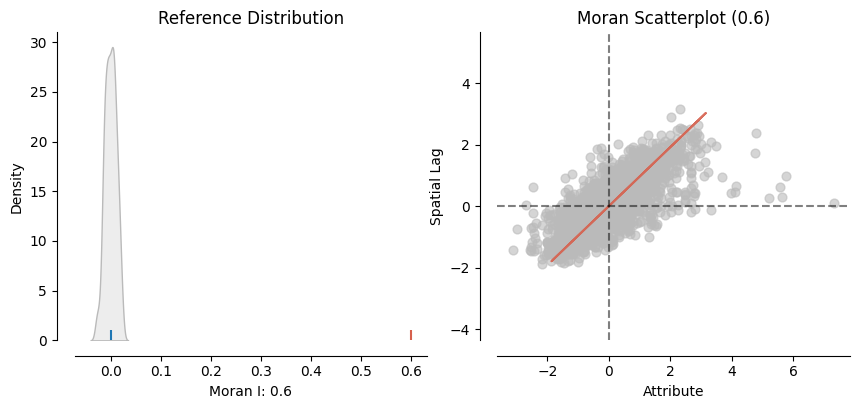

In [15]:
#Here, lets calculate the Moran's I value, and plot it.
#ols.u is the residuals from the OLS model

ols_moran = Moran(ols.u, w, permutations = 199) #199 permutations

plot_moran(ols_moran, figsize=(10,4))

We find that the Moran's I value equals 0.6, this reassures us that there is indeed a strong spatial pattern on the OLS's residuals map.

Now there are two choices:  we can use a **lag model**, or we can use an **error model**.

One convenience is that if you pass the weight matrix to the OLS function, and also specify the `spat_diag=True`, then you get some additional spatial diagnostics that can help you to decide. This also includes the Moran's I of the residuals if you specify `moran=True`.

In [16]:
ols = spreg.OLS(y, X, w=w, spat_diag=True, moran=True,
                name_y='pct_dem', name_x=variable_names)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pct_dem                Number of Observations:        3103
Mean dependent var  :     33.7616                Number of Variables   :           7
S.D. dependent var  :     16.2257                Degrees of Freedom    :        3096
R-squared           :      0.6091
Adjusted R-squared  :      0.6083
Sum squared residual:      319249                F-statistic           :    803.9833
Sigma-square        :     103.117                Prob(F-statistic)     :           0
S.E. of regression  :      10.155                Log likelihood        :  -11592.001
Sigma-square ML     :     102.884                Akaike info criterion :   23198.003
S.E of regression ML:     10.1432                Schwarz criterion     :   23240.284

------------------------------------------------------------

From the L-M Tests, we can expect that the error model is more approproate than the lag model (comparing robust score: 1186 vs 18).

### Spatial Error Model (SEM)

Now let's fit a spatial error model using `spreg.ML_Error()` where you need to specify the y, X and the weight matrix w.

In [17]:
sem = spreg.ML_Error(y, X, w=w, name_x=variable_names, name_y='new_pct_dem')

print(sem.summary)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : new_pct_dem                Number of Observations:        3103
Mean dependent var  :     33.7616                Number of Variables   :           7
S.D. dependent var  :     16.2257                Degrees of Freedom    :        3096
Pseudo R-squared    :      0.5167
Log likelihood      : -10170.5905
Sigma-square ML     :     33.4938                Akaike info criterion :   20355.181
S.E of regression   :      5.7874                Schwarz criterion     :   20397.462

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        19.00473    

The lambda (or some other software or notation using rho) coefficint for the spatially lagged error term is significant, and the magnitude is quite large, this is suggesting that there is a strong spatial autocorrelation in the residuals which is captured in the lagged error term.


Note that the sem.e_filtered property of sem is supposed to be the iid error. And the sem.u is the autoregressive error + the iid error. Now let's look at the moran's I of the residuals again.

In [18]:
sem.e_filtered

array([[-2.82249844],
       [-2.93425648],
       [ 1.76293602],
       ...,
       [ 0.58894001],
       [ 4.25853052],
       [-4.82251595]])

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.08', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (-0.08)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

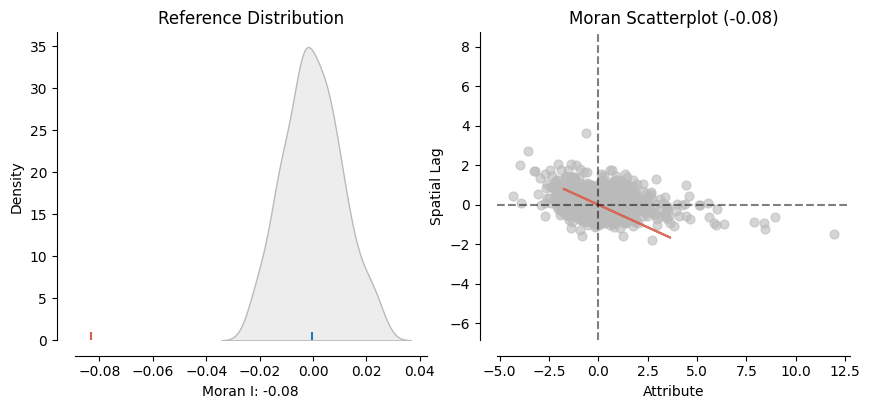

In [19]:
sem_moran = Moran(sem.e_filtered, w, permutations = 199) #199 permutations
plot_moran(sem_moran, zstandard=True, figsize=(10,4))

VERY LOW moran's I -> Random

Text(0.5, 1.0, 'Map of filtered residuals of the SEM model')

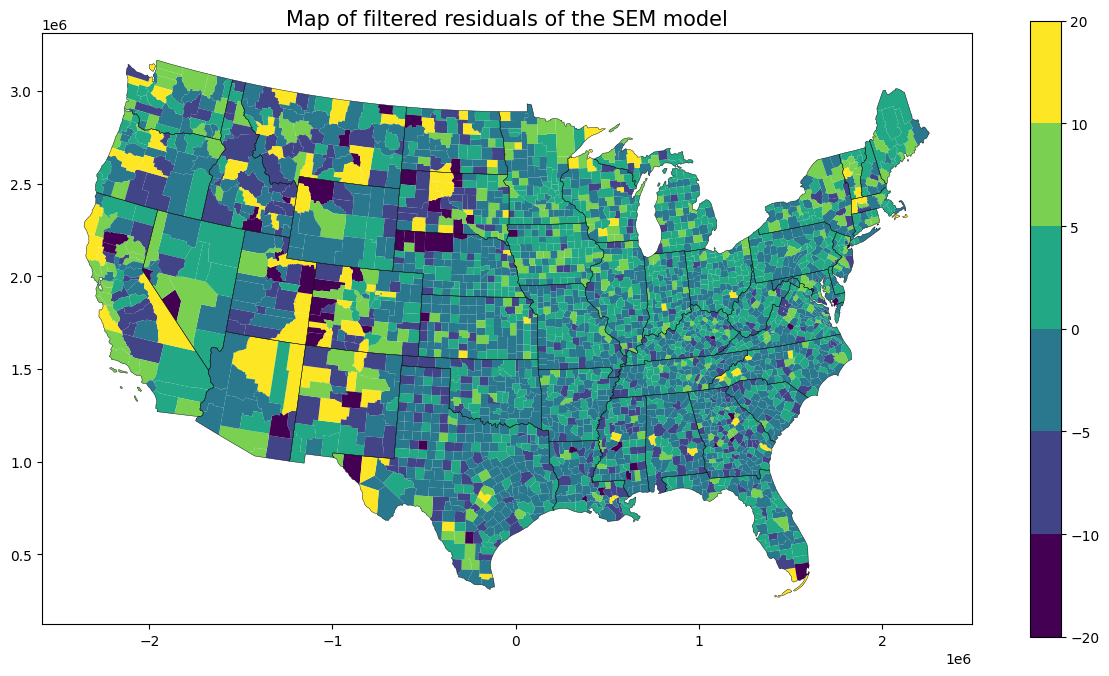

In [20]:
ax = shp_voting.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)
state.plot(ax=ax,linewidth=0.3,edgecolor="black")
plt.title("Map of filtered residuals of the SEM model",fontsize=15)


RANDOM pattern! That's great!

### Spatial Lag Model
Similarly, let's repeat this to the spatial lag model

In [21]:
slm = spreg.ML_Lag(y, X, w=w, name_y='new_pct_dem', name_x=variable_names)

print(slm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : new_pct_dem                Number of Observations:        3103
Mean dependent var  :     33.7616                Number of Variables   :           8
S.D. dependent var  :     16.2257                Degrees of Freedom    :        3095
Pseudo R-squared    :      0.7744
Spatial Pseudo R-squared:  0.5591
Log likelihood      : -10853.5647
Sigma-square ML     :     59.4991                Akaike info criterion :   21723.129
S.E of regression   :      7.7136                Schwarz criterion     :   21771.450

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

The rho coefficint for the spatially lagged term "W_new_pct_dem" is significant, and the magnitude is quite large, this is suggesting that there is a strong spatial spill over effect for the dependent variable.

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.15', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

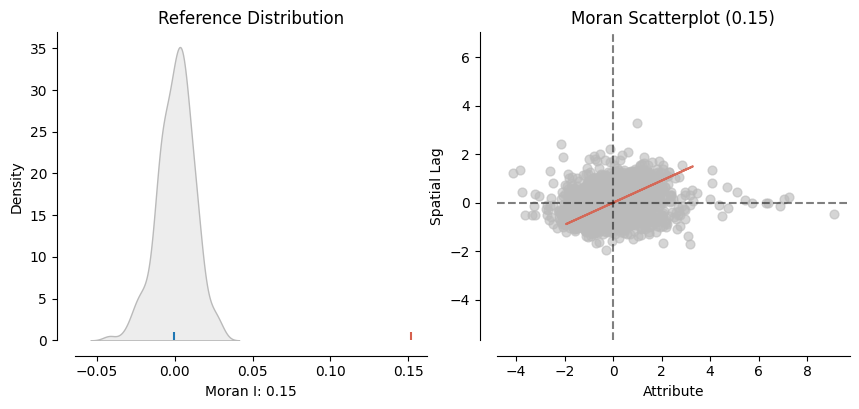

In [22]:
slm_moran = Moran(slm.u, w, permutations = 199) #199 permutations
plot_moran(slm_moran, zstandard=True, figsize=(10,4))

Text(0.5, 1.0, 'Map of residuals of the spatial lag model')

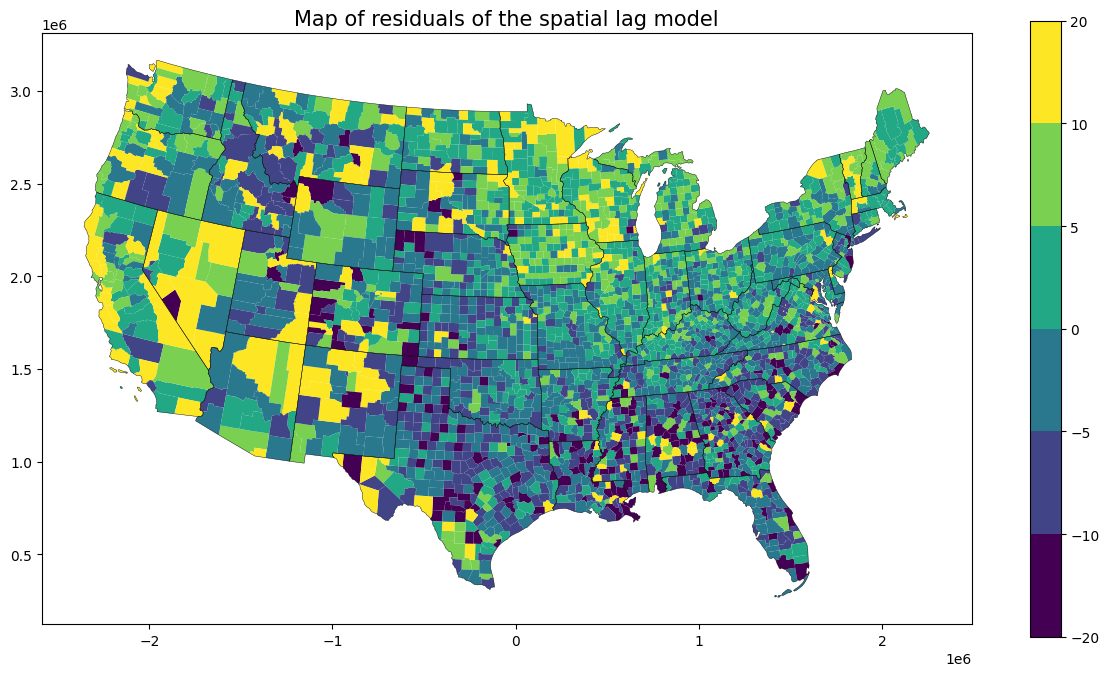

In [23]:
ax = shp_voting.plot(column=slm.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

state.plot(ax=ax,linewidth=0.3,edgecolor="black")
plt.title("Map of residuals of the spatial lag model",fontsize=15)


### Cross-comparison of Lag, Error and OLS models.

Overall, we see the estimates are consistent despite of some changes (e.g. %black gets a higher influence in SEM model). OLS model is not reliable because we know that the assumptions are violated. In the Lag model, even though we take account of the neighboring voting preference, the residuals are still showing some weak autocorrelation. And in the error model, we do observe random residuals.

So if I need to make a decision, I will use the error model. This is also supported by the evidence of the LM tests as well as that the error model has the lowest AIC value.

| Predictor    | OLS Estimates   | SLM Estimates   | SEM Estimates   |
| -----------  | ----------- | ----------- | ----------- |
| CONSTANT     | 5.83*       | 1.07        | 19.00*      |
| sex_ratio    | 0.00        | 0.01        | -0.04*      |
| pct_black    | 0.48*       | 0.27*       | 0.74*       |
| pct_hisp     | 0.23*       | 0.16*       | 0.31*       |
| pct_bach     | 0.97*       | 0.83*       | 0.72*       |
| median_income| -1.66*      | -2.99*      | -2.42*      |
| ln_pop_den   | 2.13*       | 1.47*       | 1.83*       |
| lambda       | NA          | 0.58*       | 0.86*       |
|              |             |             |             |
| AIC          | 23198.00    | 21723.12    | 20355.18    |
| Moran's I of residuals    | 0.60        | 0.15        | -0.08       |

### A little bit more on SLM model: an examination of the indirect effect.
Scenario: What if the % of bach increases 1% in Leon? What happened to the % dem in the nearby counties?

Steps:
1. get the full n by n matrix by using **w.full()**
2. calculate (I-pW)^-1*beta (here the estimate is for the %bach in SLM model, thus 0.83), now you get a full n by n change interaction.
3. find the row index of any county of interest.
4. now you can select the column of the county and exmaine how this will affect the rest of the counties.

In [24]:
#1.
w.full()[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
np.identity(3103)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [26]:
#2.
effects = np.linalg.inv(np.identity(3103) - 0.58*w.full()[0])*0.83 #n=3103, rho=0.58, est_pct_bach = 0.83

effects

array([[8.92141250e-01, 1.32877317e-03, 1.52996497e-14, ...,
        3.14050249e-31, 5.12287114e-06, 1.79564935e-10],
       [9.49123691e-04, 8.98379566e-01, 1.43986921e-13, ...,
        4.16193409e-29, 1.14493906e-03, 1.32924287e-10],
       [1.27497081e-14, 1.67984741e-13, 9.03375896e-01, ...,
        8.63302503e-23, 5.33348558e-13, 2.63149009e-21],
       ...,
       [2.61708541e-31, 4.85558978e-29, 8.63302503e-23, ...,
        8.88070682e-01, 8.55288372e-27, 1.32652812e-25],
       [3.65919367e-06, 1.14493906e-03, 4.57155907e-13, ...,
        7.33104319e-27, 8.95542764e-01, 4.10759600e-10],
       [1.12228084e-10, 1.16308751e-10, 1.97361756e-21, ...,
        9.94896087e-26, 3.59414650e-10, 9.05420698e-01]])

In [27]:
#3. find the row index for Leon, which is 67.
shp_voting[shp_voting['NAME_x'] == "Leon"]

,GEOID,STATEFP,NAME_x,county_id,geometry,state,county,NAME_y,proj_X,proj_Y,...,median_income,pct_65_over,pct_age_18_29,gini,pct_manuf,ln_pop_den,pct_3rd_party,turn_out,pct_fb,pct_uninsured
67,12073,12,Leon,12073,"POLYGON ((1080730.82089 870592.41110, 1086551....",12,73,"Leon County, Florida",1.120705e+06,889449.6751,...,5.3106,12.9,30.040722,0.4896,2.0,6.023568,1.202364,71.910474,6.8,8.1
1050,48289,48,Leon,48289,"POLYGON ((-30255.42040 920246.79226, -30598.62...",48,289,"Leon County, Texas",3.831304e+02,913423.2253,...,4.3045,24.2,12.342525,0.5271,5.7,2.767577,0.899446,68.074417,5.2,17.0


In [28]:
#Total effects for Leon can be obtained in the diagnoal of the full effects matrix.

effects[67,67]

0.903899945968712

This is indicating that 1 % increase in college graduates will result in a total effect (direct + indirect) of ~0.90 %increase in dem vote share. Note this is larger than the coefficient from the lag model (i.e., 0.83) which only captures the direct effect.
The indirect effect is as a consequence of spatial interaction between itself and its neighbors, which is ~ 0.07% (0.90 - 0.83)



Now lets exmaine how the change in Leon affects surrounding counties.

Text(0.5, 1.08, '% increase in Dem share if Leon has \n1% more college graduates')

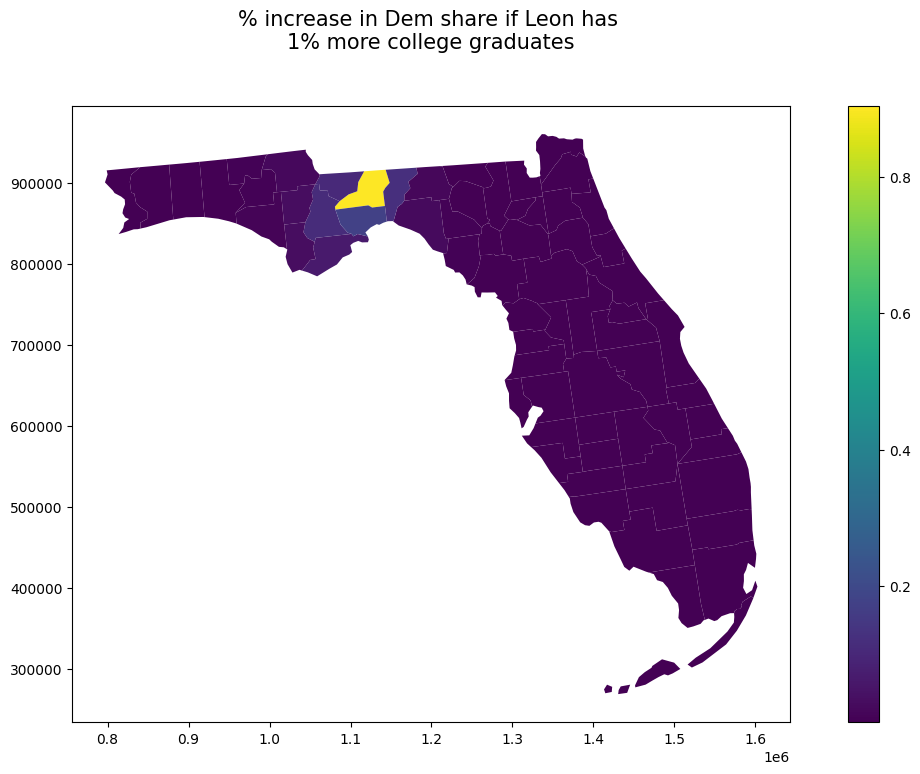

In [29]:
#get the effects for leon and plot it
shp_voting['d_pct_bach_leon'] = effects[:,67]


ax = shp_voting[shp_voting['state'] == 12].plot(column='d_pct_bach_leon',legend=True,
                                                figsize=(15,8), linewidth=0.0,aspect=1)

plt.title("% increase in Dem share if Leon has \n1% more college graduates",fontsize=15,y=1.08)

In [30]:
shp_voting[(shp_voting['state'] == 12) & (shp_voting['NAME_x'] == "Jefferson")].d_pct_bach_leon

2808    0.121902
Name: d_pct_bach_leon, dtype: float64

So basically we can see that if Leon has 1% more college graduates, it is expected that the %dem share will increase ~0.12% in the nearby counties. For example, Jefferson county may have 0.12% increase in the dem share influenced by the change in Leon.

In [31]:
shp_voting[(shp_voting['state'] == 12) & (shp_voting['NAME_x'] == "Miami-Dade")].d_pct_bach_leon

2607    1.163942e-08
Name: d_pct_bach_leon, dtype: float64

However, we can see that for a further away county such as Miami-Dade, the indirect spill over effect is basically zero. This is due to both the magnitude of the effect (rho) as well as the specified W matrix is quite local.